In [1]:
import pandas as pd
from tqdm.auto import tqdm
from tqdm import tqdm
import torch
import regex
from collections import Counter
import matplotlib.pyplot as plt 
from fast_histogram import histogram1d
import networkx as nx
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)
tqdm.pandas()

In [2]:
data = pd.read_parquet("../results/dhd-corpus.parquet")
data.bib.map(type).value_counts()
data["bib"] = data.bib.map (lambda x: eval(x))
data["publication_type"] = data["publication_type"].map(lambda x:{"paper": "vortrag"}.get(x,x))

In [3]:
data.columns

Index(['title', 'authors', 'affiliation', 'publication_type', 'file',
       'filetype', 'keywords', 'topics', 'text', 'bib', 'year', 'subcategory',
       'cities'],
      dtype='object')

# Bibliographies for 2014 and 2015 are missing
Number of extracted bibliographies per year. Note, that it is possible to retrieve empty bibliographies!
2014, 2015 are missing.

In [4]:
data.groupby("year")["bib"].aggregate(lambda x: sum(~x.isna()))

year
2014      0
2015      0
2016    160
2017     92
2018    160
2019    137
2020    137
2022    154
2023    136
Name: bib, dtype: int64

## Removing all empty or None bibliographies

In [5]:
data = data[~(data.bib.isna() | data.bib.map(lambda x: x == "nan"))]
data.head()

title  \
index                                                                                                  
0                                                                              Die Rolle des Zeigens   
1      Der Modelle Tugend 2.0 – Vom digitalen 3D-Datensatz zum wissenschaftlichen Informationsmodell   
2                        Vernetzung ist wichtig, Vernetzung ist gut - Aber wie vernetzt man richtig?   
3                               Datenzentren für die nachhaltige Forschung in den Digital Humanities   
4                                 Fachwissenschaftliche Nutzungsszenarien der CLARIN-D Infrastruktur   

                                                                                                                     authors  \
index                                                                                                                          
0                                                                                                           Kepper, Johannes   
1       Hoppe, Stephan; Pfarr-Harfst, Mieke; Münster, Sander; Kuroczyński, Piotr; Blümel, Ina; Hauck, Oliver; Lutteroth, Jan   
2                                                                                          Pfeil, Patrick; Aehnlich, Barbara   
3      Sahle, Patrick; Trippel, Thorsten; Neumann, Gerald; Engelhardt, Claudia; Kurzawe, Daniel; Schäfer, Felix; Wörner, Kai   
4                    Wiedemann, Gregor; Gloning, Thomas; Blätte, Andreas; Keller, Maret; Haaf, Susanne; Würzner, Kay-Michael   

                                                                                                                                                                                                                                                                                                                                                                                                               affiliation  \
index                                                                                                                                                                                                                                                                                                                                                                                                                        
0                                                                                                                                                                                                                                                                                                                                                         Musikwissenschaftliches Seminar Detmold / Paderborn, Deutschland   
1                                                                                                                                                                            Ludwig-Maximilians-Universität München; Technische Universität Darmstadt; Technische Universität Dresden; Herder-Institut Marburg; Technische Informationsbibliothek Hannover; Institut für Raumdarstellung; Technische Universität Darmstadt   
2                                                                                                                                                                                                                                                                                                                                                   Universität Leipzig, Deutschland; Friedrich--Schiller-Universität Jena   
3      Data Center for the Humanities, Universität zu Köln; CLARIN-D, Universität Tübingen; Berlin-Brandenburger Akademie der Wissenschaften; Humanities Data Center, Staats- und Universitätsbibliothek Göttingen; Humanities Data Center, Staats- und Universitätsbibliothek Göttingen; IANUS, Deutsches Archäologisches Institut; Geisteswissenschaftliche Infrastruktur für Nachhaltigkeit (gwin), Universi

## Create list of all citation objects

In [6]:
data.bib = data.bib.map(lambda x: [regex.sub("\s+", " ", s) if isinstance(s, str) else s for s in x]).copy()
lcites = sum(data.bib.to_list(),[])

In [7]:
import regex
import string

def clean(x):
    """Reduce the bib items to ascii_letters"""
    return "".join(c for c in x.lower() if c in string.ascii_letters + " ")

def tokenize(x):
    """Tokenize by whitespaces"""
    s = [token for token in regex.split("[/ \n]",clean(x)) if token !=""]
    return s

def ngrams(x, ngrams=[3]):
    """Create per token ngrams with padding"""
    ngrams = [(" "*(n-1) + t + " "*(n-1))[i:(i+n)] for t in tokenize(x) for n in ngrams for i in range(0, len(t)) if len(t)>=n]
    return ngrams


### Embedding the ngrams intro lower dimensional space (cmp. Random Indexing) for fast comparisons

In [8]:
dim = 768
ns = [3,4]
def hash_embedding(x):
    idx = Counter([abs(hash(t)) % dim for t in ngrams(x, ns)])
    hash_tensor = torch.sparse_coo_tensor([list(idx.keys())], list(idx.values()), size=(dim,),
                                              device="cpu").float().unsqueeze(0)
    return hash_tensor

e = torch.cat([hash_embedding(x) for x in tqdm(lcites)], dim =0).to_dense()
e = e/e.norm(p=2, dim=-1, keepdim=True)

100%|███████████████████████████████████| 11179/11179 [00:05<00:00, 2220.27it/s]



### Similarity is now a matrixs multriplication away

Text(0.5, 1.0, 'Similarity Histogram')

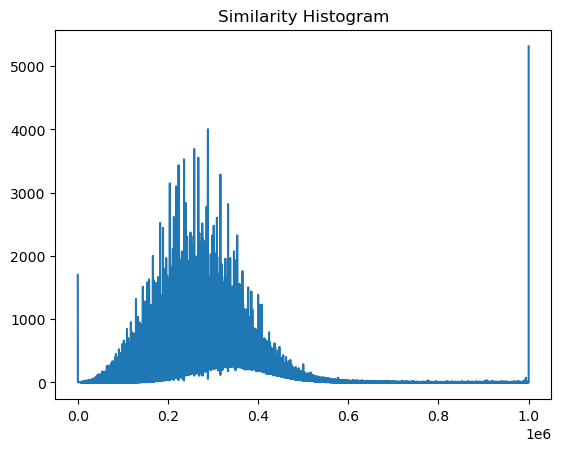

In [9]:
r = torch.mm(e,e.t())
plt.plot(histogram1d(r.flatten(), bins=1000000, range=[0,1]))
plt.title("Similarity Histogram")

In [10]:
(r>0.8).float().mean() , 11179 / 11179/11179

(tensor(0.0002), 8.94534394847482e-05)

0.8 Would result in 0.02 percent of all possible pairs being duplicates. ( compare to 0.00008, percent of pairs if they were unique)

### This can be directly formed into a network
In a graph the clique algorithm can be used to detect duplicate groups

In [11]:
graph = nx.from_numpy_array((r>0.8).numpy())

In [12]:
dup_groups = [x for x in list(nx.find_cliques(graph))]
dup_groups

[[0],
 [1, 1192],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7, 7581],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21, 472],
 [21, 10994, 10992, 9403],
 [21, 10988, 10992, 9403],
 [21, 10988, 10997],
 [22],
 [23],
 [24],
 [25, 4455, 2321, 1866, 892, 5966],
 [26,
  9096,
  977,
  1383,
  1652,
  2171,
  6494,
  1147,
  718,
  9682,
  9149,
  8830,
  5000,
  6897],
 [26,
  9096,
  977,
  1383,
  1652,
  2171,
  6494,
  1147,
  718,
  9682,
  9149,
  8830,
  5000,
  4678],
 [26,
  9096,
  977,
  1383,
  1652,
  2171,
  6494,
  1147,
  718,
  9682,
  9149,
  8830,
  120,
  6897],
 [26,
  9096,
  977,
  1383,
  1652,
  2171,
  6494,
  1147,
  718,
  9682,
  9149,
  8830,
  120,
  4678],
 [26,
  9096,
  977,
  1383,
  1652,
  2171,
  6494,
  477,
  5000,
  6897,
  1736,
  9682,
  9149,
  2938],
 [26,
  9096,
  977,
  1383,
  1652,
  2171,
  6494,
  477,
  5000,
  6897,
  1736,
  9682,
  9149,
  718],
 [26, 9096, 977, 1383, 1652, 2171, 6494, 477, 5000, 6897

In [13]:
for element in dup_groups[1]:
    print(lcites[element] + "\n")

Bremer, Thomas / Molitor, Paul / Ritter, Jörg / Solms, Hans-Joachim (eds.) (2012-2015): SaDA. Semi-automatische Differenzanalyse von komplexen Textvarianten. Martin-Luther-Universität Halle http://www.informatik.uni-halle.de/ti/forschung/ehumanities/sada/ [letzter Zugriff 08. Januar 2016].

Bremer, Thomas / Molitor, Paul / Ritter, Jörg / Solms, Hans-Joachim(2012-2015): Semi-automatische Differenzanalyse von komplexen Textvarianten http://sada.uzi.uni-halle.de [letzter Zugriff 15. Oktober 2015].



### Merging duplicates groups if they intersect 

In [14]:
def merge(lsts):
    sets = [set(lst) for lst in lsts if lst]
    merged = True
    while merged:
        merged = False
        results = []
        while sets:
            common, rest = sets[0], sets[1:]
            sets = []
            for x in rest:
                if x.isdisjoint(common):
                    sets.append(x)
                else:
                    merged = True
                    common |= x
            results.append(common)
        sets = results
    return sets
merge(dup_groups)

[{0},
 {1, 1192},
 {2},
 {3},
 {4},
 {5},
 {6},
 {7, 7581},
 {8},
 {9},
 {10},
 {11},
 {12},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19},
 {20},
 {21,
  53,
  310,
  415,
  416,
  472,
  1056,
  1133,
  1258,
  1259,
  1317,
  1796,
  1865,
  2683,
  3004,
  3861,
  4795,
  4852,
  5303,
  5477,
  5657,
  6914,
  6930,
  7062,
  7572,
  7590,
  7972,
  8724,
  8728,
  8956,
  9180,
  9196,
  9403,
  9960,
  10806,
  10988,
  10992,
  10994,
  10997,
  11001,
  11002,
  11022},
 {22},
 {23},
 {24},
 {25, 475, 892, 1649, 1866, 1944, 2321, 4455, 5103, 5966},
 {26,
  115,
  120,
  477,
  718,
  977,
  1147,
  1383,
  1391,
  1652,
  1736,
  2171,
  2425,
  2426,
  2427,
  2428,
  2531,
  2897,
  2938,
  3602,
  3772,
  4678,
  5000,
  5558,
  6117,
  6352,
  6494,
  6897,
  8830,
  9096,
  9149,
  9682,
  9735,
  10956},
 {27},
 {28},
 {29, 254, 1742},
 {30, 221, 288, 762, 1395},
 {31, 35},
 {32},
 {33, 769, 2178, 2880},
 {34},
 {36},
 {37},
 {38},
 {39, 7445},
 {40},
 {41},
 {42},
 {4

### With these groups we define a representative name for each group (the lowest index) and rename the items before counting.

In [15]:
name_mappings = { lcites[v]:lcites[min(group)] for group in dup_groups for v in group}
name_mappings_rev = {lcites[min(group)]:[lcites[v] for v in group] for group in dup_groups }
renamed_lcites = [name_mappings.get(x,x) for x in lcites]
c = Counter(renamed_lcites)

Resulting in a sorted list by citations

In [16]:
toplist = sorted(c.items(), key= lambda x: -x[1])
toplist = pd.DataFrame(toplist).rename(columns={0:"publication", 1:"citation"})
toplist.to_excel("../results/top_external_citation.xlsx")
toplist[:20]

,publication,citation
0,"Jannidis, Fotis / Kohle, Hubertus / Rehbein, Malte (eds.): Digital Humanities. Eine Einführung . Stuttgart: J. B. Metzler.",49
1,"Blei, David M. / Ng, Andrew Y. / Jordan, Michael I. (2003): ""Latent dirichlet allocation"", in: The Journal of machine Learning research 3: 993-1022.",20
2,"Wilkinson, M. / Dumontier, M. / Aalbersberg, I. et al. (2016): “The FAIR Guiding Principles for scientific data management and stewardship.” Sci Data 3 , 160018. doi:10.1038/sdata.2016.18",17
3,"McCallum, Andrew K. (2002): ""MALLET: MAchine Learning for LanguagE Toolkit"" http://mallet.cs.umass.edu/about.php.",15
4,"Rat für Informationsinfrastrukturen (2016): Leistung aus Vielfalt: Empfehlungen zu Strukturen, Prozessen und Finanzierung des Forschungsdatenmanagements in Deutschlandhttp://www.rfii.de/de/category/dokumente/ [letzter Zugriff 25. August 2016].",15
5,"The TEI Consortium (2015): TEI P5: Guidelines for Electronic Text Encoding and Interchange, Version 2.8.0 TEI Consortium http://www.tei-c.org/Guidelines/P5/ [letzter Zugriff 9. Oktober 2015].",13
6,"Blei, David M. (2011): “Introduction to Probabilistic Topic Models,” in: Communication of the ACM.",12
7,"Gius, Evelyn, und Janina Jacke. 2017. „The Hermeneutic Profit of Annotation. On preventing and fostering disagreement in literary text analysis“. International Journal of Humanities and Arts Computing 11 (2): 233–54.",12
8,"Hamp, Birgit / Feldweg, Helmut (1997): „GermaNet - a Lexical-Semantic Net for German“, in: Proceedings of the ACL Workshop Automatic Information Extraction and Building of Lexical Semantic Resources for NLP Applications, Madrid, Spanien 9-15.",11
9,"Moretti, Franco (2013): Distant Reading. London: Verso.",11


lookup if the duplication grouping make sense with the index in the top list:

In [17]:
name_mappings_rev[toplist["publication"][0]]

['Jannidis, Fotis / Kohle, Hubertus / Rehbein, Malte (eds.): Digital Humanities. Eine Einführung . Stuttgart: J. B. Metzler.',
 'Jannidis, Fotis / Kohle, Hubertus / Rehbein Malte (eds.) (2017): Digital Humanities. Eine Einführung. Stuttgart: Metzler.',
 'Jannidis, Fotis / Kohle, Hubertus / Rehbein, Malte (2017)(eds.): Digital Humanities. Eine Einführung, Stuttgart: J. B. Metzler.',
 'Jannidis, Fotis / Kohle, Hubertus / Rehbein, Malte (2017):Digital Humanities. Eine Einführung. Stuttgart: J. B. Metzler.',
 'Jannidis, Fotis / Kohle, Hubertus / Rehbein, Malte (2017): Digital Humanities: Eine Einführung. Stuttgart: Metzler.',
 'Jannidis, Fotis / Kohle, Hubertus / Rehbein, Malte (2017): Digital Humanities. Eine Einführung. Stuttgart: Metzler.',
 'Kohle, H. 2017. „Digitales Publizieren“. In Digital Humanities. Eine Einführung, hg. Von F-Jannidis, H. Kohle und M. Rehbein, 199–205. Stuttgart: J.B. Metzler.',
 'Kohle, Hubertus (2017): “Digitales Publizieren” in: Jannidis, Fotis / Kohle, Hubertu

In [18]:
name_mappings_rev[toplist["publication"][8]]

['Hamp, Birgit / Feldweg, Helmut (1997): „GermaNet - a Lexical-Semantic Net for German“, in: Proceedings of the ACL Workshop Automatic Information Extraction and Building of Lexical Semantic Resources for NLP Applications, Madrid, Spanien 9-15.',
 'Hamp, Birgit / Feldweg, Helmut (1997): „GermaNet - a Lexical-Semantic Net for German“, in: Automatic information extraction and building of lexical semantic resources for NLP applications.',
 'Hamp, Birgit / Feldweg, Helmut (1997): „GermaNet - a Lexical-Semantic Net for German“, in: Proceedings of the ACL workshop Automatic Information Extraction and Building of Lexical Semantic Resources for NLP Applications. Madrid.',
 'Hamp, Birgit/Feldweg, Helmut (1997): “GermaNet – a Lexical-Semantic Net for German.” In: Proceedings of the ACL workshop Automatic Information Extraction and Building of Lexical Semantic Resources for NLP Applications. Madrid: 9–15.',
 'Hamp, Birgit / Feldweg, Helmut (1997): "GermaNet - a Lexical-Semantic Net for German." P

# Plot over time

In [19]:
bibtime = data.explode("bib")
bibtime.bib = bibtime.bib.map(lambda x: name_mappings.get(x,x))

In [20]:
plot_items = [x for x in toplist["publication"][:10]] # Collect the top 10 publications

bibtime = bibtime[bibtime.bib.map(lambda x: x in plot_items)]
p = bibtime.groupby("year").bib.value_counts().to_frame()
p.columns = ["count"]
p = p.reset_index()

<Axes: title={'center': 'Top'}, xlabel='year'>

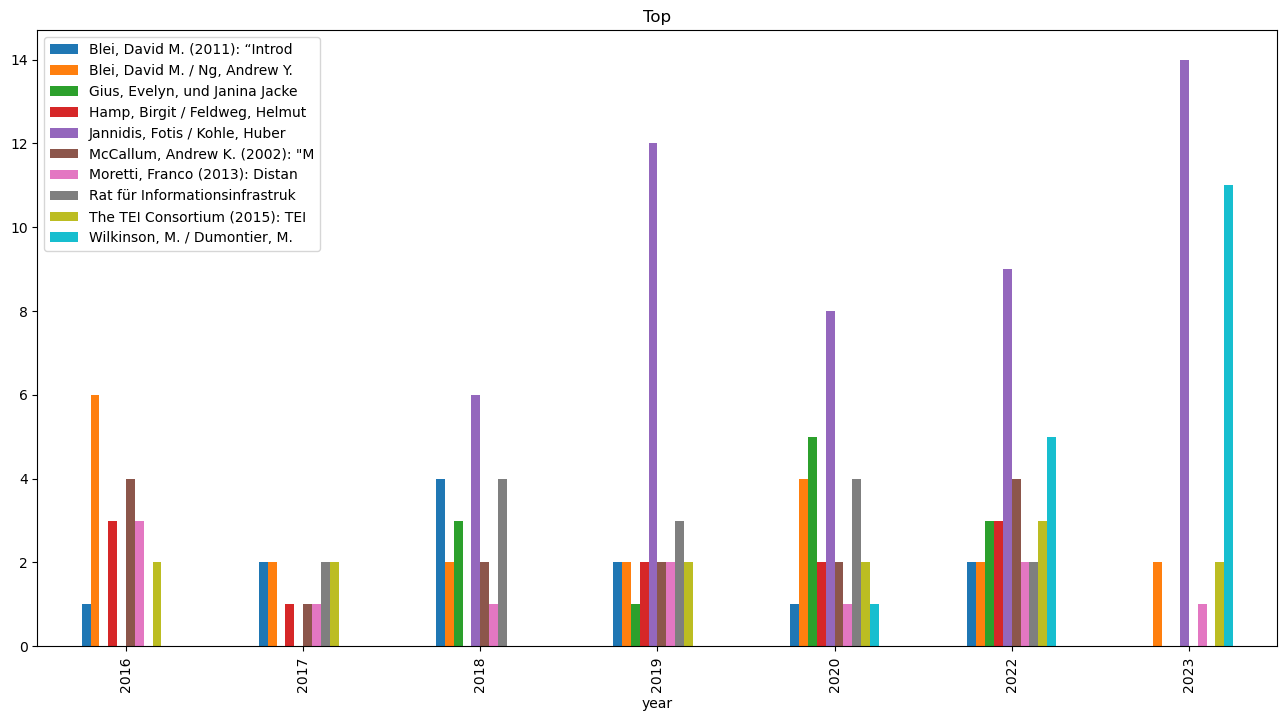

In [21]:
p.bib = p.bib.map(lambda x: x[:30]) # shorten the name for the legend

data_per_year = p[["bib", "year", "count"]].groupby(["bib", "year"]).mean()
data_per_year.index.names = ["","year"]
fig, ax = plt.subplots(figsize=(16,8))
data_per_year["count"].unstack(level=0).plot(kind="bar", ax=ax, title="Top")


# Extract Publication Years of Bibliography Entries (highly experimental)


Many are tricky because they also have many 4-digit numbers (such as page numbers, arxive IDs, or Years in the title). In those cases the first matched number proved reliable.

Most of them use either `[authors] ([year]):` or `[authors]. [year].`

If there is not year found with this pattern, there's a semi-matching pattern for multiple years `(2014-2015)` in which case the latter is preferred.
This also should cover access dates for websites: `[letzter Zugriff 13. Februar 2016]`


In [22]:
def extract_year(x):
    """Well, well, well"""
    #years = (regex.findall("[^/_0-9?=&A-Za-z–-] ?([0-9]{4})[^/_0-9?=&–-]", x))
    years = sum([list(x) for x in regex.findall("\( ?([0-9]{4})[a-d]?\)| ([0-9]{4})[a-d]?[;\.]|\(([0-9]{4}), ", x)],[])
    years = [y for y in years if y !=""]
    if years ==  [] : 
        years = sum([list(x) for x in regex.findall("[ .]([0-9]{4})\]|[. –-]([0-9]{4})\)|/ ([0-9]{4})\)", x)],[])
        years = [y for y in years if y !=""]
        #print(x, years, "\n")
    if years ==  [] : 
        years = sum([list(x) for x in regex.findall(" ([0-9]{4}),|-([0-9]{4})\)| ([0-9]{4}):|\)([0-9]{4}).?$", x)],[])
        years = [y for y in years if y !=""]
    years = [y for y in years if int(y) <= 2023 ]
    if years == []: print(x, years, "\n")
    return int(years[0]) if len(years) > 0 else None

    
def extract(x):
    years = [extract_year(b) for b in x]
    return [int(y) if y is not None else None for y in years ]

### This extracts the citation years of all publication where this is easy to extract, it prints out only the entryies where nothing is extracted:

In [23]:
data["citation_years"] = data.bib.map(extract).to_list()

Hughes, Lorna / Constantopoulos, Panos / Dallas, Costis (Im Druck): “Digital Methods in the Humanities: Understanding and Describing their Use across the Disciplines”, in Schreibman, Susan / Siemens, Ray / Unsworth, John (eds.): A new companion to digital humanities. Oxford: Wiley-Blackwell. [] 

International Organization for Standardization (o. J.): Date and time format – ISO 8601. http://www.iso.org/iso/iso8601 [letzter Zugriff 15. Oktober 2015]. [] 

Wikipedia: ISO 8601. https://de.wikipedia.org/wiki/ISO_8601 [letzter Zugriff 15. Oktober 2015]. [] 

Schingnitz, Barbara / Schweizer, Tobias: "SALSAH in der Nutzung durch die Anton Webern-Gesamtausgabe", in: Ahrend, Thomas / Schmidt, Matthias (eds.) (in Vorbereitung): Webern-Studien. 3: Webern-Philologien. [] 

Digital Humanities Austria: http://clarin.arz.oeaw.ac.at/dha/. [] 

 [] 

 [] 

Ullrich, Anna Valentine / Jakobs, Eva-Maria / Eraßme, Denise (im Druck): „„ich schreib das mal hier rein ähm“. Modality-taking – Schreibhinweise in 

### Many citations are (in Vorbereitung, im Druck, eingereicht....) in the camera-ready version....

0.0584016393442623

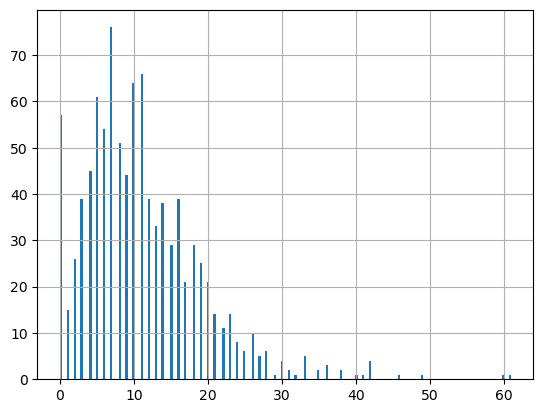

In [24]:
data.citation_years.map(lambda x: len([e for e in x if e is not None])).hist(bins=200)#,data.bib.map(len).hist(bins=200)
data.citation_years.map(lambda x: len([e for e in x if e is not None])==0).mean()

For 5% of publications, no publication years could be extacted

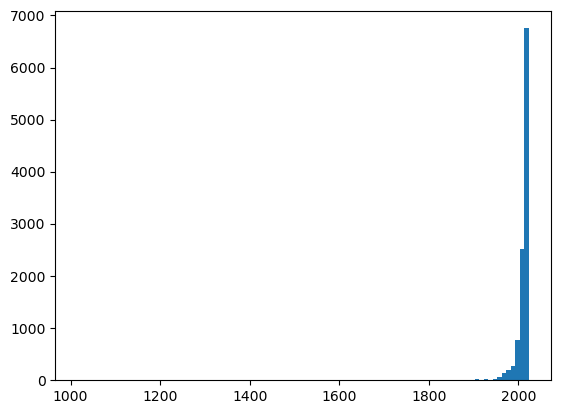

In [25]:
_ = plt.hist(sum(data.citation_years.map(lambda x: [y for y in x if y is not None]).to_list(),[]), bins=100)


# What was cited before 1900 ?

### Errors
There seem to be many mistakes regarding things like citations:
For example the regex would prefer the latter of two numbers in the first () after authors. This seems to be a typo in the second entry here:

In [26]:
r = range(0,1900)
print("\n\n".join(data[data.citation_years.map(lambda x: any(y in r for y in x))][["bib", "citation_years"]].apply(
    lambda x: "\n\n".join([",".join((k,str(v))) for k,v in zip(x["bib"], x["citation_years"]) if v in r]), axis=1).values.tolist()))

Heinrich Woelfli's Syrische Reise 1520, aus dem Lateinischen übersetzt von Johann Haller 1582, Burgerbibliothek Bern, Signatur Mss.h.h.XX.168,1520

Universität Wien (2014-1016): e-Infrastructures Austriahttp://e-infrastructures.at/ [letzter Zugriff 09. Februar 2016].,1016

Böhtlingk, Otto (1886): Pāṇini’s Grammatik. Leipzig: Verlag von H. Haessel.,1886

Matthias von Edessa (Mattʿēos Uṙhayecʿi) (1898): Die Croniken des Matthias von Edessa Žamanakagrutʿiwn. Vałaršapat.,1898

Humboldt, Alexander von (1845): Kosmos. Entwurf einer physischen Weltbeschreibung, 1. Stuttgart u. a.: Deutsches Textarchiv. http://www.deutschestextarchiv.de/humboldt_kosmos01_1845 [letzter Zugriff 15. Oktober 2015].,1845

N.N. (1827): Die physikalische Geographie von Herrn Alexander v. Humboldt, vorgetragen im Semestre 1827/28. Berlin: Deutsches Textarchiv. http://www.deutschestextarchiv.de/nn_oktavgfeo79_1828/7 [letzter Zugriff 15. Oktober 2015].,1827

Von Foerster, Wendelin (1876): Li Dialoge Gregoire lo Pape. 

## Explicit errors can be mapped here:
the mapping is between full element and year. This dictionary will remap those items present in the list:

In [27]:
errormap={
    "Universität Wien (2014-1016): e-Infrastructures Austriahttp://e-infrastructures.at/ [letzter Zugriff 09. Februar 2016].":2016
}

In [28]:
data["citation_years"] = data.apply(lambda x: [errormap.get(k,v) for k,v in zip(x["bib"], x["citation_years"])], axis=1)

# Recency of Citations or the average age of a citation

In [29]:
def recency(pub_year, cit_years):
    """Average distance from publication year"""
    cit_years = [cy for cy in cit_years if cy is not None]
    diffs = [int(pub_year)-cy for cy in cit_years]
    return sum(diffs) / len(diffs) if len(diffs) > 0 else 0

In [30]:
data["Recency"] = data.apply(lambda x: recency(x["year"], x["citation_years"]), axis=1)

In [31]:
def recency_boxplot(by, outlier=True, bound=100):
    if not outlier :
        data[(data.Recency >0 )& (data.Recency <bound)].boxplot("Recency", by=[by],figsize=(16,8))
    else:
        data[data.Recency >0].boxplot("Recency", by=[by],figsize=(16,8))
    plt.title('Recency of Citations')
    plt.suptitle('')
    plt.ylabel("Average Age of Citation")

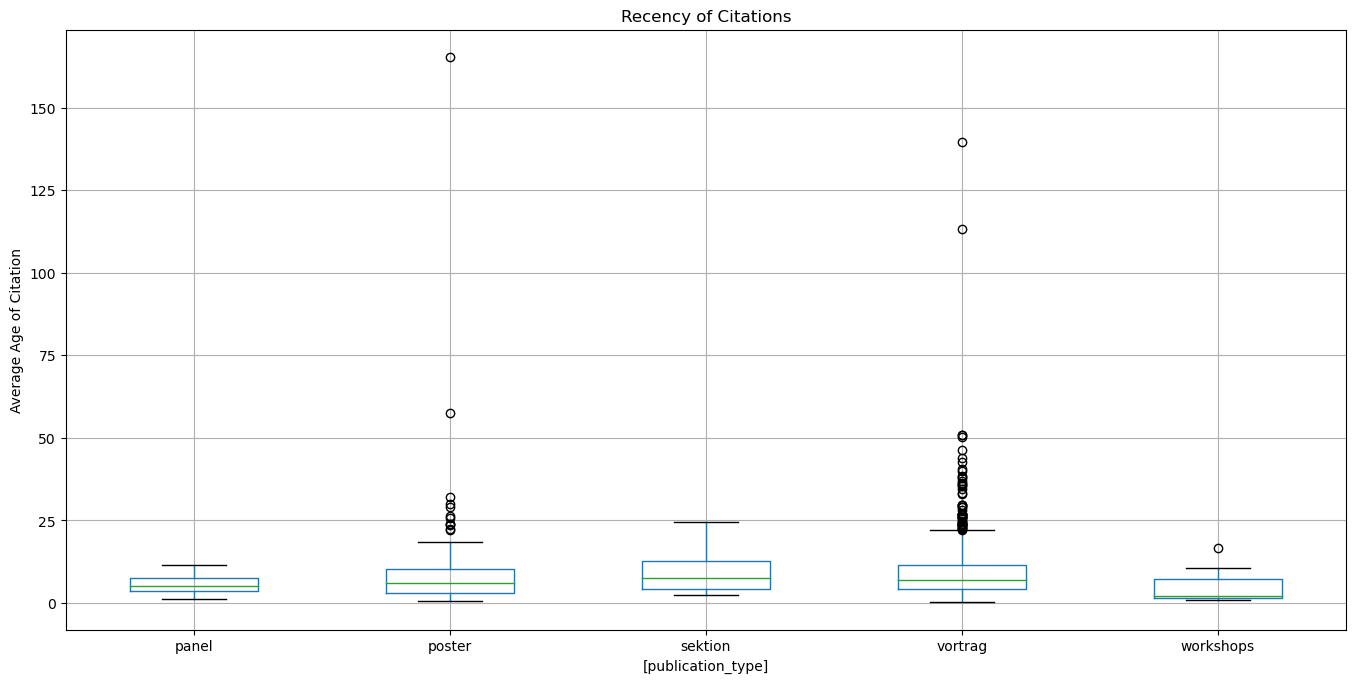

In [32]:
recency_boxplot("publication_type", outlier=True)


Text(0.28, 0.69, 'Kinder des Buchdrucks (2018)')

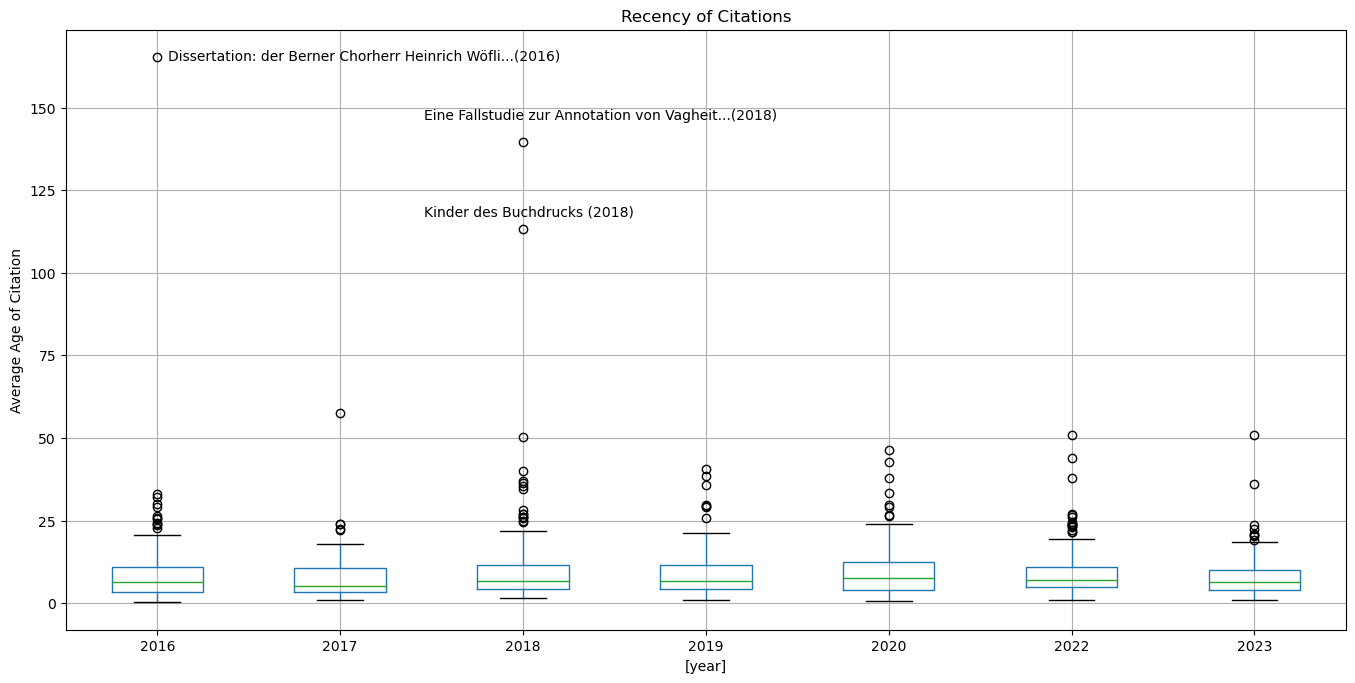

In [33]:
recency_boxplot("year", outlier=True)
plt.annotate('Dissertation: der Berner Chorherr Heinrich Wöfli...(2016)', xy=(0.08, 0.95), xycoords='axes fraction')
plt.annotate('Eine Fallstudie zur Annotation von Vagheit...(2018)', xy=(0.28, 0.85), xycoords='axes fraction')
plt.annotate('Kinder des Buchdrucks (2018)', xy=(0.28, 0.69), xycoords='axes fraction')

outlier:
- [Dissertation: der Berner Chorherr Heinrich Wöfli...(2016)](https://github.com/DHd-Verband/DHd-Abstracts-2016/blob/main/PDF-files/posters-019.pdf)

- [Eine Fallstudie zur Annotation von Vagheit...(2018)](https://github.com/DHd-Verband/DHd-Abstracts-2018/blob/main/PDF-files_original/VERTAN_Cristina_Eine_Fallstudie_zur_Annotation_von_Vagheit_i.pdf)

- ["Kinder des Buchdrucks" (2018)](https://github.com/DHd-Verband/DHd-Abstracts-2018/blob/main/PDF-files_original/BURR_Elisabeth__Kinder_des_Buchdrucks__im_Digitalen_Zeitalte.pdf)



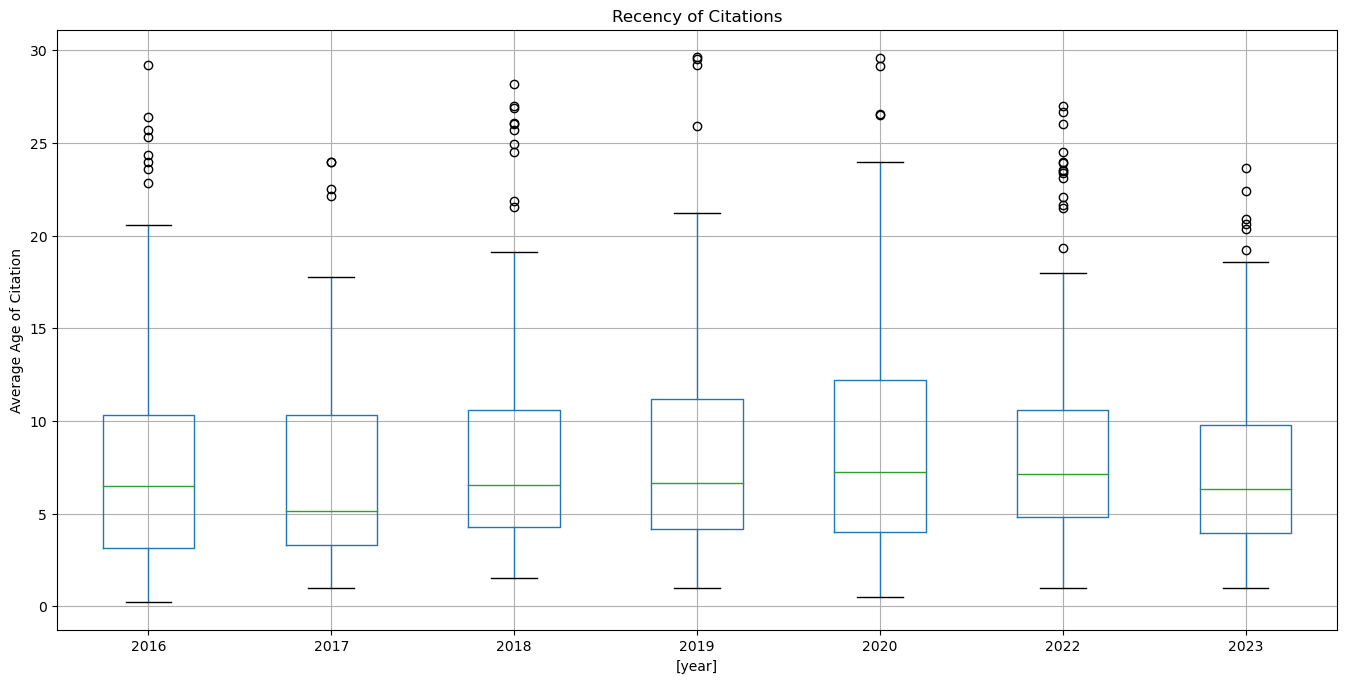

In [34]:
recency_boxplot("year", outlier=False, bound=30)


In [35]:
data.sort_values("Recency", ascending=False)[["year","file", "title", "bib", "Recency"]].head()

year                                                              file  \
index                                                                           
26     2016                                                   posters-019.xml   
154    2018  VERTAN_Cristina_Eine_Fallstudie_zur_Annotation_von_Vagheit_i.xml   
19     2018  BURR_Elisabeth__Kinder_des_Buchdrucks__im_Digitalen_Zeitalte.xml   
26     2017                                                  poster-KLUGH.xml   
125    2023  VOGELER_Georg_Building_a_virtual_research_environment_to_mov.xml   

                                                                                                                                                                                                                                    title  \
index                                                                                                                                                                                                                                       
26     Dissertation: Der Berner Chorherr Heinrich Wölfli (1470-1532) und die Beschreibung seiner Heiligland-Wallfahrt von 1520/21 - Erschliessung und Darstellung durch klassisch-literaturwissenschaftliche und digital-moderne Methoden   
154                                                                                                                                                               Eine Fallstudie zur Annotation von Vagheit in Werken Dimitrie Cantemirs   
19                                                                                                                                            "Kinder des Buchdrucks" im Digitalen Zeitalter. Ein romanistisches Digital Humanities Modul   
26                                                                                                                                                                                                                      Grotefend digital   
125                                                                                                                               Building a virtual research environment to move from digital to distant Diplomatics (ERC project DiDip)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [36]:
list(zip(*data.loc[86][["bib", "citation_years"]].iloc[5].values))[:10]

[('Duncan, A. M. (1981): “Styles of Language and Modes of Chemical Thought" in: Ambix 28/2: 83–107.',
  1981),
 ('Eco, Umberto (2016): “Il Discorso Alchemico E Il Segreto Differito" in: I Limiti Dell’interpretazione (Prima Edizione 1990), 97–116. La nave di Teseo.',
  2016),
 ('Feuerstein-Herz, Petra (2017): “Alchemie Portal der Herzog August Bibliothek Wolfenbüttel.” Herzog August Bibliothek Wolfenbüttel. http://alchemie.hab.de.',
  2017),
 ('Fors, Hjalmar / Principe, Lawrence / Sibum, Otto (2016): “From the Library to the Laboratory and Back Again: Experiment as a Tool for Historians of Science" in: Ambix 63/2: 85–97.',
  2016),
 ('Frietsch, Ute (2017): “Alchemie Thesaurus." Herzog August Bibliothek Wolfenbüttel. 2017. http://alchemie.hab.de/thesaurus.',
  2017),
 ('Frietsch, Ute (2021): “Obscurum Vocabulum: Begriffe der frühneuzeitlichen Alchemie und der Alchemie-Thesaurus der Herzog August Bibliothek" in: Feuerstein-Herz, Petra / Frietsch, Ute (eds.): Alchemie – Genealogie und Term

In [37]:
data["yeardiff"] = data.apply(lambda x: [int(x["year"])-int(y) for y in x["citation_years"] if y is not None], axis=1)
#data.explode("yeardiff")[["year", "yeardiff"]].plot(x="year", y="yeardiff",kind="scatter")

In [ ]:
_tmp = data.copy()
_tmp.topics = _tmp.topics.str.split("; ")


topktopics = [e[0] for e in sorted(Counter(sum(_tmp["topics"], [])).items(), key=lambda x: -x[1])[:20]]
_tmp = _tmp.explode("topics")
_tmp = _tmp[_tmp.topics.map(lambda x: x in topktopics)]
_tmp[(_tmp.Recency >0) & (_tmp.Recency <100)].boxplot("Recency", by=["topics"],figsize=(16,8), rot=90)
plt.title('Recency of Citations')
plt.suptitle('')
plt.ylabel("Average Age of Citation")

Text(0, 0.5, 'Average Age of Citation')